In [1]:

import cv2
from datetime import datetime
from pathlib import Path
from mpl_toolkits import mplot3d
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
DATETIME_STR = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

PRINT_PROGRESS_EVERY_N_PERCENT = 1

ADD_TIME_TO_FILENAME = True

############### PF #############
WIDTH = 1280
HEIGHT = 720
FPS = 60

# Format from DarkLabel software: (frame_index, classname, instance_id, is_difficult, x, y, w, h) 
#                                      0            1          2            3         4  5  6  7

# Format for events: (x, y, t (us or ms), p)
EVENTS_CSV_X_COL = 0
EVENTS_CSV_Y_COL = 1
EVENTS_CSV_T_COL = 2
EVENTS_CSV_P_COL = 3

# Paths
TRAJECTORIES_CSV_DIR = Path("output/extracted_trajectories")
OUTPUT_BASE_DIR = Path("output/inspect_trajectory_hist")

EVENTS_CSV_HAS_HEADER = False
LABELS_CSV_HAS_HEADER = False

##################################

# Precision of the timestamp: for mikroseconds: 1000000, for milliseconds: 1000
TIMESTEPS_PER_SECOND = 1_000_000
# If timestamp in mikroseconds: -> mikroseconds per frame
TIMESTEPS_PER_FRAME = (1 / FPS) * TIMESTEPS_PER_SECOND
HALF_FRAME_TIME = TIMESTEPS_PER_FRAME // 2
T_SCALE = 0.002 # 0.002 is good
INV_T_SCALE = 1 / T_SCALE

T_BUCKET_WIDTH = 1000 * 100 # in us; 50 or 100ms is good?
BINS_PER_T_BUCKET = 250 # for the tx, ty projection: Sub-bins per bucket on the t axis

SAVE_IMAGE_DPI = 300


np.set_printoptions(suppress=True,precision=3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)


In [14]:
# Find all files from directory
# trajectory_files = TRAJECTORIES_CSV_DIR.glob("*_trajectories*/*.csv")

# trajectory_filepath = TRAJECTORIES_CSV_DIR / "hauptsächlichBienen1_trajectories_2024-06-02_13-08-11/hauptsächlichBienen1_id9_pts38695_start7674867.csv"
# trajectory_filepath = TRAJECTORIES_CSV_DIR / "vieleSchmetterlinge2_trajectories_2024-05-30_11-31-51/42.csv"
# trajectory_filepath = TRAJECTORIES_CSV_DIR / "1_l-l-l_trajectories_2024-05-29_15-27-12/2.csv"
trajectory_filepath = TRAJECTORIES_CSV_DIR / "3_classified/_with_bboxes/hauptsächlichBienen1_trajectories_bbox/9_bee_pts20400_start5289327.csv"
# trajectory_filepath = TRAJECTORIES_CSV_DIR / "3_classified/hauptsächlichBienen1_trajectories/9_bee_pts18648_start5289327.csv"

In [15]:
df = pd.read_csv(trajectory_filepath, sep=',', header="infer")
print(df.head())
print(df["bb_corner_index"].unique())

     x    y     t    r    g    b  is_confident  bb_frame_index  \
0  765  504 0.000  255  255  255             1             634   
1  765  505 0.198  255  255  255             1             634   
2  764  504 0.272  255  255  255             1             634   
3  764  504 0.926  255  255  255             1             634   
4  764  508 1.226  255  255  255             1             634   

   bb_corner_index  
0               -1  
1               -1  
2               -1  
3               -1  
4               -1  
[-1  0  1  2  3  4  5  6  7]


In [11]:
t_col_real = df.loc[:,"t"] * INV_T_SCALE
df["t_real"] = t_col_real
print(t_col_real[t_col_real < 0.0].head())

max_t = t_col_real.iloc[-1]
print("max_t", max_t)

max_t_str = f"{int((max_t / TIMESTEPS_PER_SECOND) // 60):0>2}m:{(max_t / TIMESTEPS_PER_SECOND % 60):0>2.2f}s"
print("max_t_str", max_t_str)


# Biene hat 200 flügelschläge pro sek. Das sind 5ms pro flügelschlag.
# Es sollen 10 Flügelschläge in ein Fenster passen. Also 5*10=50ms oder 50000us
number_of_buckets = int(np.ceil(max_t/T_BUCKET_WIDTH))

print("Die Bahn hat", number_of_buckets, "buckets von jeweils", T_BUCKET_WIDTH//1000, "ms")

t_col_buckets = t_col_real.floordiv(T_BUCKET_WIDTH).astype('Int64')
df["t_bucket"] = t_col_buckets
print(t_col_buckets.unique())


t_col_buckets = t_col_buckets[t_col_buckets!=-1]

event_counts_per_bucket = t_col_buckets.value_counts(sort=False).sort_index()
print(event_counts_per_bucket)
print(len(event_counts_per_bucket.index))

20   -1274.000
21   -1274.000
22   -1274.000
23   -1274.000
Name: t, dtype: float64
max_t 1826157.333333333
max_t_str 00m:1.83s
Die Bahn hat 19 buckets von jeweils 100 ms
<IntegerArray>
[0, -1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
Length: 20, dtype: Int64
0      439
1      943
2     1007
3      886
4     1365
5     1165
6     1123
7     1316
8     1214
9     2286
10    1685
11    1375
12     964
13    1013
14     962
15     818
16     789
17     866
18     180
Name: t, dtype: Int64
19


## Hist for Number of events per time frame of a Trajectory

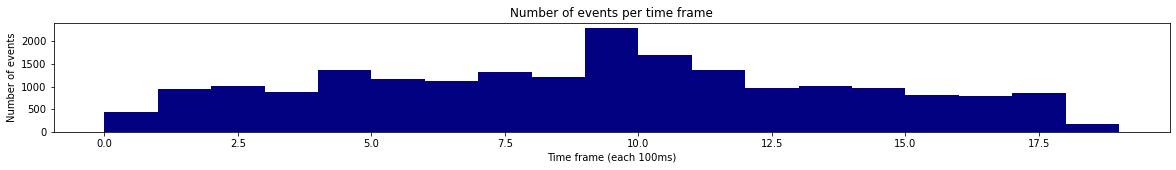

In [6]:
fig = plt.figure(figsize = (20, 2))
 
# creating the bar plot
plt.bar(list(range(number_of_buckets)), event_counts_per_bucket, color='navy', width=1.0, align="edge")
 
plt.xlabel(f"Time frame (each {T_BUCKET_WIDTH//1000}ms)")
plt.ylabel("Number of events")
plt.title("Number of events per time frame")
plt.show()


## Project Trajectory to 2D plane: Only use (t,x) or (t,y)

In [7]:
def get_projected_heatmap(df, col1, col2, bins_x, bins_y):
    df_proj = df.loc[:,[col1, col2]]

    t_max = df_proj[col1].iloc[-1]
    # [[xmin, xmax], [ymin, ymax]]
    ty_hist_range = [ [0, int(t_max)], [0, bins_y] ]

    heatmap, xedges, yedges = np.histogram2d(df_proj[col1], df_proj[col2], bins=[bins_x, bins_y], density=False, range=ty_hist_range)
    heatmap = heatmap.T
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    # heatmap = np.log2(heatmap+1)
    return df_proj, heatmap, extent

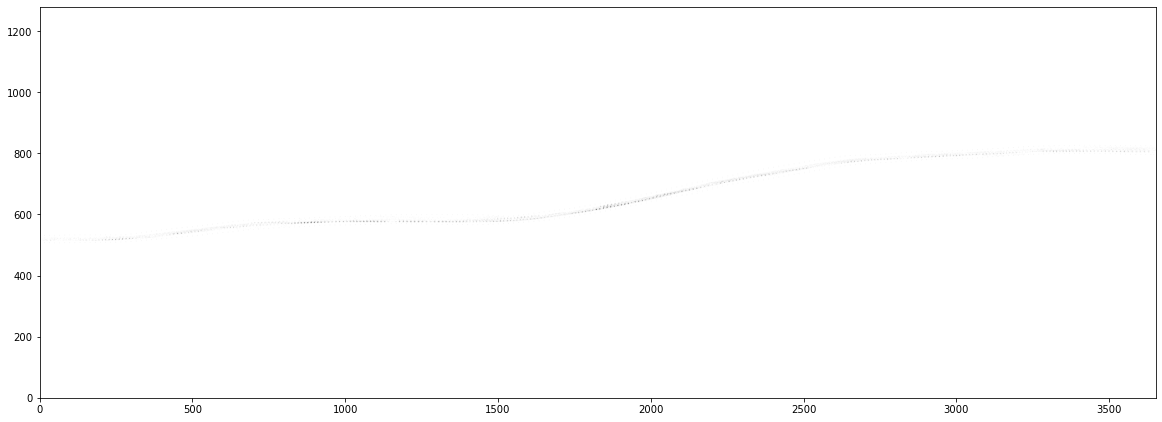

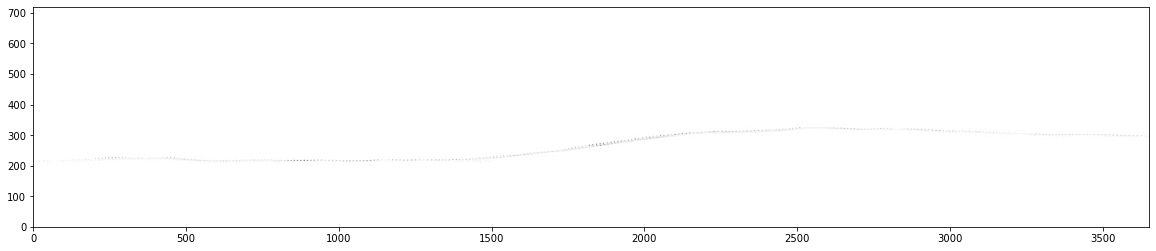

In [8]:
tx_df, tx_heatmap, tx_extent = get_projected_heatmap(df, "t", "x", number_of_buckets*BINS_PER_T_BUCKET, WIDTH)
log_tx_heatmap = np.log2(tx_heatmap+1)
plt.figure(figsize = (20, 10))
# plt.xlim(left=0, right=number_of_buckets)
plt.imshow(log_tx_heatmap, extent=tx_extent, origin='upper', cmap="Greys")
plt.show()

ty_df, ty_heatmap, ty_extent = get_projected_heatmap(df, "t", "y", number_of_buckets*BINS_PER_T_BUCKET, HEIGHT)
log_ty_heatmap = np.log2(ty_heatmap+1)
plt.figure(figsize = (20, 10))
# plt.xlim(left=0, right=number_of_buckets)
plt.imshow(log_ty_heatmap, extent=ty_extent, origin='upper', cmap="Greys")
plt.show()

Wie ty und tx kombinieren?
x und y range auf 0 bis 1 normalisieren, dann x*y rechnen?

## Combined chart

In [9]:
# colors for bars in events histogram
bar_colors = []
good_number = 4096
for x in event_counts_per_bucket:
    if x >= good_number*2:
        bar_colors.append("navy")
    elif x >= good_number:
        bar_colors.append("royalblue")
    elif x >= good_number//2:
        bar_colors.append("orange")
    else:
        bar_colors.append("tomato")

<BarContainer object of 19 artists>

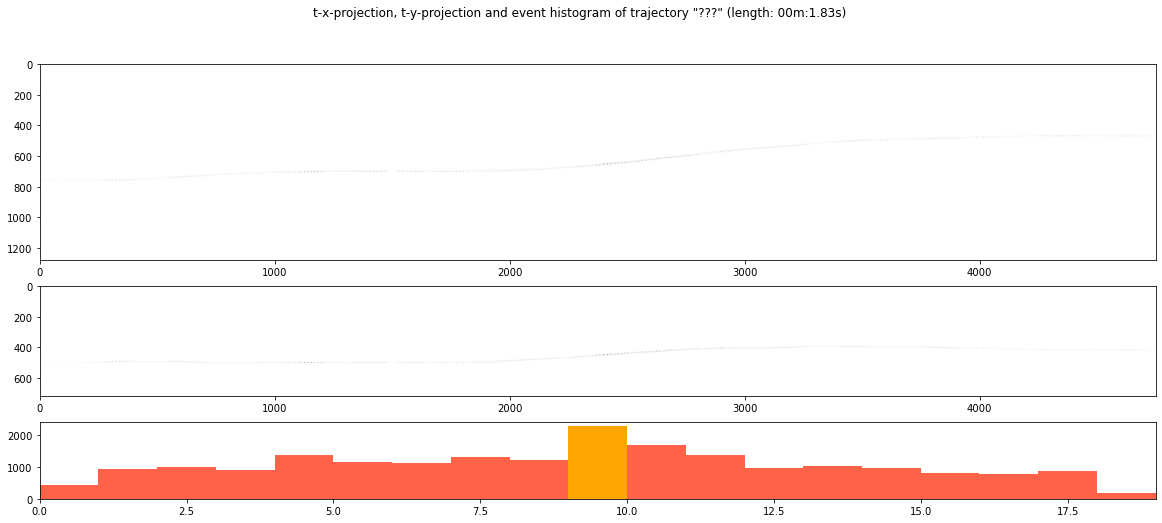

In [10]:



fig, axs = plt.subplots(3, gridspec_kw={'height_ratios': [1280,720,500]})
fig.set_size_inches(20, 8)
# fig.set_figwidth(20)
fig.suptitle(f't-x-projection, t-y-projection and event histogram of trajectory "???" (length: {max_t_str})')

axs[0].imshow(log_tx_heatmap, origin='upper', cmap="Greys", aspect="auto")

axs[1].imshow(log_ty_heatmap, origin='upper', cmap="Greys", aspect="auto")

axs[2].set_xlim(left=0, right=number_of_buckets)
axs[2].bar(list(range(number_of_buckets)), event_counts_per_bucket, width=1.0, align="edge", color=bar_colors)


-> Histogramm ist wie erste Ableitung von t-y-Projektion! 



## Export part of projected trajectory as pretty image
### First find bbox around used part of the image

In [11]:
# Return bbox indices of bbox around all non zero values
def arg_bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    ymin, ymax = np.nonzero(rows)[0][[0, -1]]
    xmin, xmax = np.nonzero(cols)[0][[0, -1]]
    return ymin, ymax+1, xmin, xmax+1

def hist2d_to_image(arr):
    max_val_ln = np.log(arr.max()+1)
    # log1p is ln(x+1)
    arr = np.log1p(arr) / max_val_ln # -> [0, 1]
    # make 0=white (=255), 1=black (=0)
    arr = ((arr * -1) + 1.0) * 255.0
    return arr

491 519 0 248
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
shape (28, 250) float64
0.0 245.0914721361293 255.0
[[255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 ...
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]]


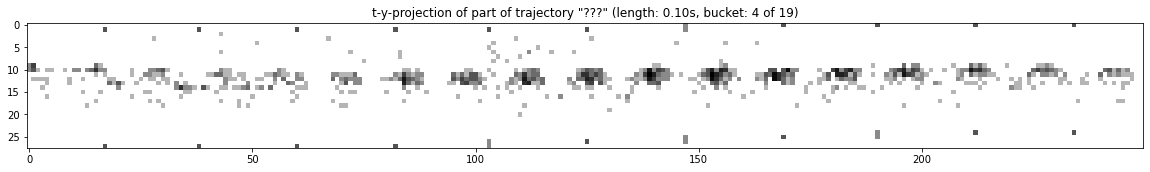

In [12]:
bucket_index = 4
t_start = BINS_PER_T_BUCKET*bucket_index
t_length = BINS_PER_T_BUCKET
t_length_real = (t_length / BINS_PER_T_BUCKET) * T_BUCKET_WIDTH
t_length_str = f"{(t_length_real / TIMESTEPS_PER_SECOND):0>2.2f}s"
t_end = t_start+t_length

ty_heatmap_tcrop = ty_heatmap[:,t_start:t_end]

# print(ty_heatmap.shape)
# print(ty_heatmap)
# print(np.argmax(ty_heatmap, axis=0)) # findet pro spalte den 
# print(np.argmax(ty_heatmap, axis=0).shape)
# print(np.argmax(ty_heatmap, axis=1).shape)

# Crop to used area
ymin, ymax, xmin, xmax = arg_bbox(ty_heatmap_tcrop)
print(ymin, ymax, xmin, xmax)
ty_heatmap_tycrop = ty_heatmap_tcrop[ymin:ymax,:]

nonzero_mask = (ty_heatmap_tycrop != 0).astype(float)
zero_mask = (ty_heatmap_tycrop == 0).astype(float)
print(nonzero_mask)

# ty_heatmap_tycrop = np.log1p(ty_heatmap_tycrop)
# ty_heatmap_tycrop = np.log10(np.minimum(ty_heatmap_tycrop + zero_mask, 10)) * nonzero_mask

ty_heatmap_tycrop = hist2d_to_image(ty_heatmap_tycrop)

print("shape", ty_heatmap_tycrop.shape, ty_heatmap_tycrop.dtype)
print(ty_heatmap_tycrop.min(), ty_heatmap_tycrop.mean(), ty_heatmap_tycrop.max())
print(ty_heatmap_tycrop)

# Show image
plt.figure(figsize = (20, 10))
plt.title(f't-y-projection of part of trajectory "???" (length: {t_length_str}, bucket: {bucket_index} of {number_of_buckets})')
# plt.xlim(left=0, right=number_of_buckets)
plt.imshow(ty_heatmap_tycrop, origin='upper', cmap="gray")
plt.show()

# Save image with OpenCV
filename = "orig_res_" + datetime.now().strftime("%Y-%m-%d_%H-%M-%S") + ".png"
filepath = "output/figures/trajectory_images/" + filename
cv2.imwrite(filepath, ty_heatmap_tycrop) # muss rgb sein?

# Save with PLT
filename = "plt_" + datetime.now().strftime("%Y-%m-%d_%H-%M-%S") + ".png"
filepath = "output/figures/trajectory_images/" + filename
fig = plt.figure(frameon=False)
ax = fig.add_subplot()
ax.imshow(ty_heatmap_tycrop, aspect='equal', interpolation="none", cmap="gray")
ax.axis('off')
ax.margins(0)
plt.savefig(filepath, format="png", bbox_inches="tight", pad_inches=0, dpi=SAVE_IMAGE_DPI)
plt.close()


## 3d visualizations

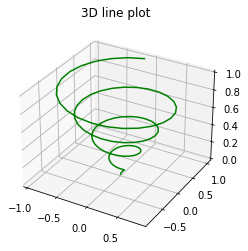

In [13]:
fig = plt.figure()
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
 
# defining all 3 axis
z = np.linspace(0, 1, 100)
x = z * np.sin(25 * z)
y = z * np.cos(25 * z)
 
# plotting
ax.plot3D(x, y, z, 'green')
ax.set_title('3D line plot')
plt.show()


In [14]:
trajectory_filepath = TRAJECTORIES_CSV_DIR / \
    "3_classified/_with_bboxes/hauptsächlichBienen1_trajectories_bbox/fragments_time_100ms_4096pts_2024-06-10_23-45-35/9_bee_pts20400_start5289327/frag_9.csv"
# trajectory_filepath = TRAJECTORIES_CSV_DIR / \
#     "3_classified_pf1/_with_bboxes/hauptsächlichBienen1_trajectories_bbox/fragments_time_4000ms_4096pts_2024-06-12_15-10-31/18_bee_pts34743_start10928909/frag_1.csv"
# trajectory_filepath = TRAJECTORIES_CSV_DIR / \
#     "2_separated_2024-06-09_14-46-59/_with_bboxes/1_l-l-l_trajectories_bbox/fragments_time_100ms_4096pts_2024-06-10_23-17-48/0_ins_pts1073898_start1476947/frag_90.csv"

df = pd.read_csv(trajectory_filepath, sep=',', header="infer")
print(df.head())

events_df = df.loc[df["bb_corner_index"].astype(int) == -1]
bb_events_df = df[df["bb_corner_index"].astype(int) >= 0]

print(len(events_df), len(events_df.index), len(bb_events_df))

     x    y      t    r    g    b  is_confident  bb_frame_index  \
0  649  441 -0.038  127  255  212             0             742   
1  676  441 -0.038  127  255  212             0             742   
2  649  473 -0.038  127  255  212             0             742   
3  676  473 -0.038  127  255  212             0             742   
4  669  461  0.228  255  255  255             1             742   

   bb_corner_index  
0                0  
1                1  
2                2  
3                3  
4               -1  
4096 4096 88


In [15]:
bboxes = {} # frame, bbox points
for i,row in bb_events_df.iterrows():
    x = int(row["x"])
    y = int(row["y"])
    t = float(row["t"])
    fi = int(row["bb_frame_index"])
    corner = int(row["bb_corner_index"])
    if fi not in bboxes:
        bboxes[fi] = {}
    if corner >= 0:
        bboxes[fi][corner] = (x,y,t)

# for k,v in bboxes.items():
#     print(len(v), k,v)

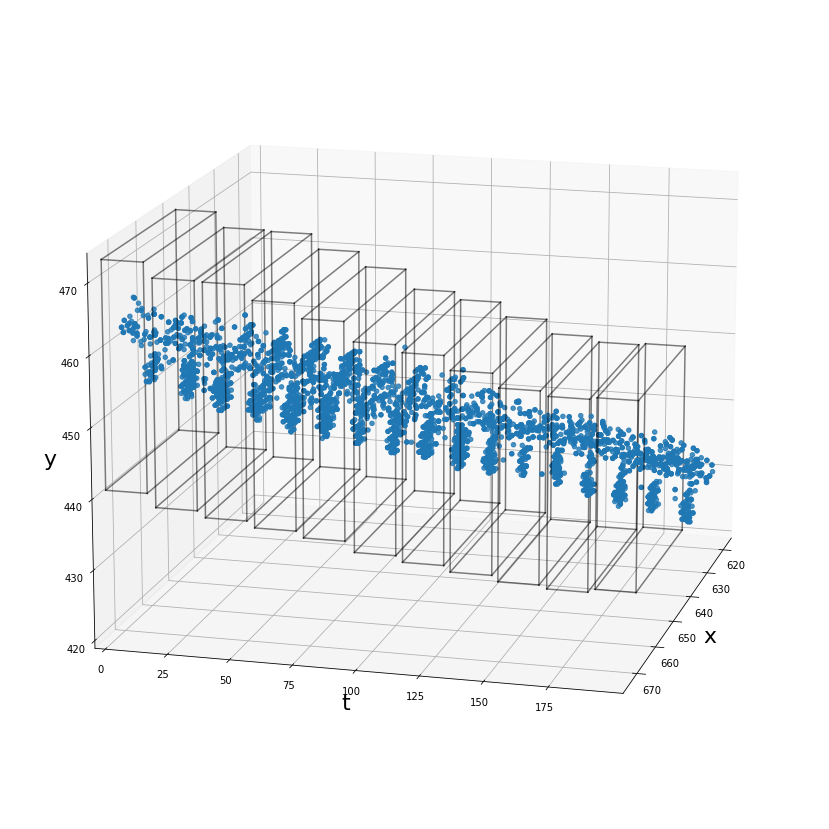

In [16]:


fig = plt.figure(figsize=(15,15))
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d',computed_zorder=False)

# syntax for 3-D projection
x = events_df["x"]
y = events_df["y"]
t = events_df["t"]
c = events_df["bb_frame_index"].astype(int)
ax.scatter(x, t, y, alpha=0.8, cmap='cool', zorder=1)

# xx = np.array([0,1,0,1,0,1,0,1]) * 20 + 640
# tt = np.array([0,0,0,0,1,1,1,1]) * 20 + 100
# yy = np.array([0,0,1,1,0,0,1,1]) * 20 + 440

lines_start = [0,0,2,1,4,4,6,5,0,1,2,3]
lines_end =   [1,2,3,3,5,6,7,7,4,5,6,7]
lines_zorder= [2,2,2,2,0,0,0,0,0,0,1,1]
for k,bb in bboxes.items():
    if len(bb) != 8:
        continue
    for i in range(len(lines_start)):
        a = lines_start[i]
        b = lines_end[i]
        zo = lines_zorder[i]
        pointa = bb[a]
        pointb = bb[b]
        ax.plot([pointa[0],pointb[0]], [pointa[2],pointb[2]], [pointa[1],pointb[1]], color='black', alpha=0.5, zorder=zo)

# syntax for plotting
ax.set_xlabel('x', fontsize=22)
ax.set_ylabel('t', fontsize=22)
ax.set_zlabel('y', fontsize=22)
ax.elev = 15
ax.azim = 15
# ax.axis('off')
ax.margins(0)
plt.show()

In [ ]:
# Fragmented by time
# frag_1.csv - frag7.csv
dir = "output/extracted_trajectories/_from_h5/1_l-l-l_trajectories/fragmented4096_windows1/3"




